In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
N = np.arange(1,101,1)
D = 3
mdyn = 140/N
mstruc = N-1

[11]


/tmp/ipykernel_53004/2143303252.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper left')


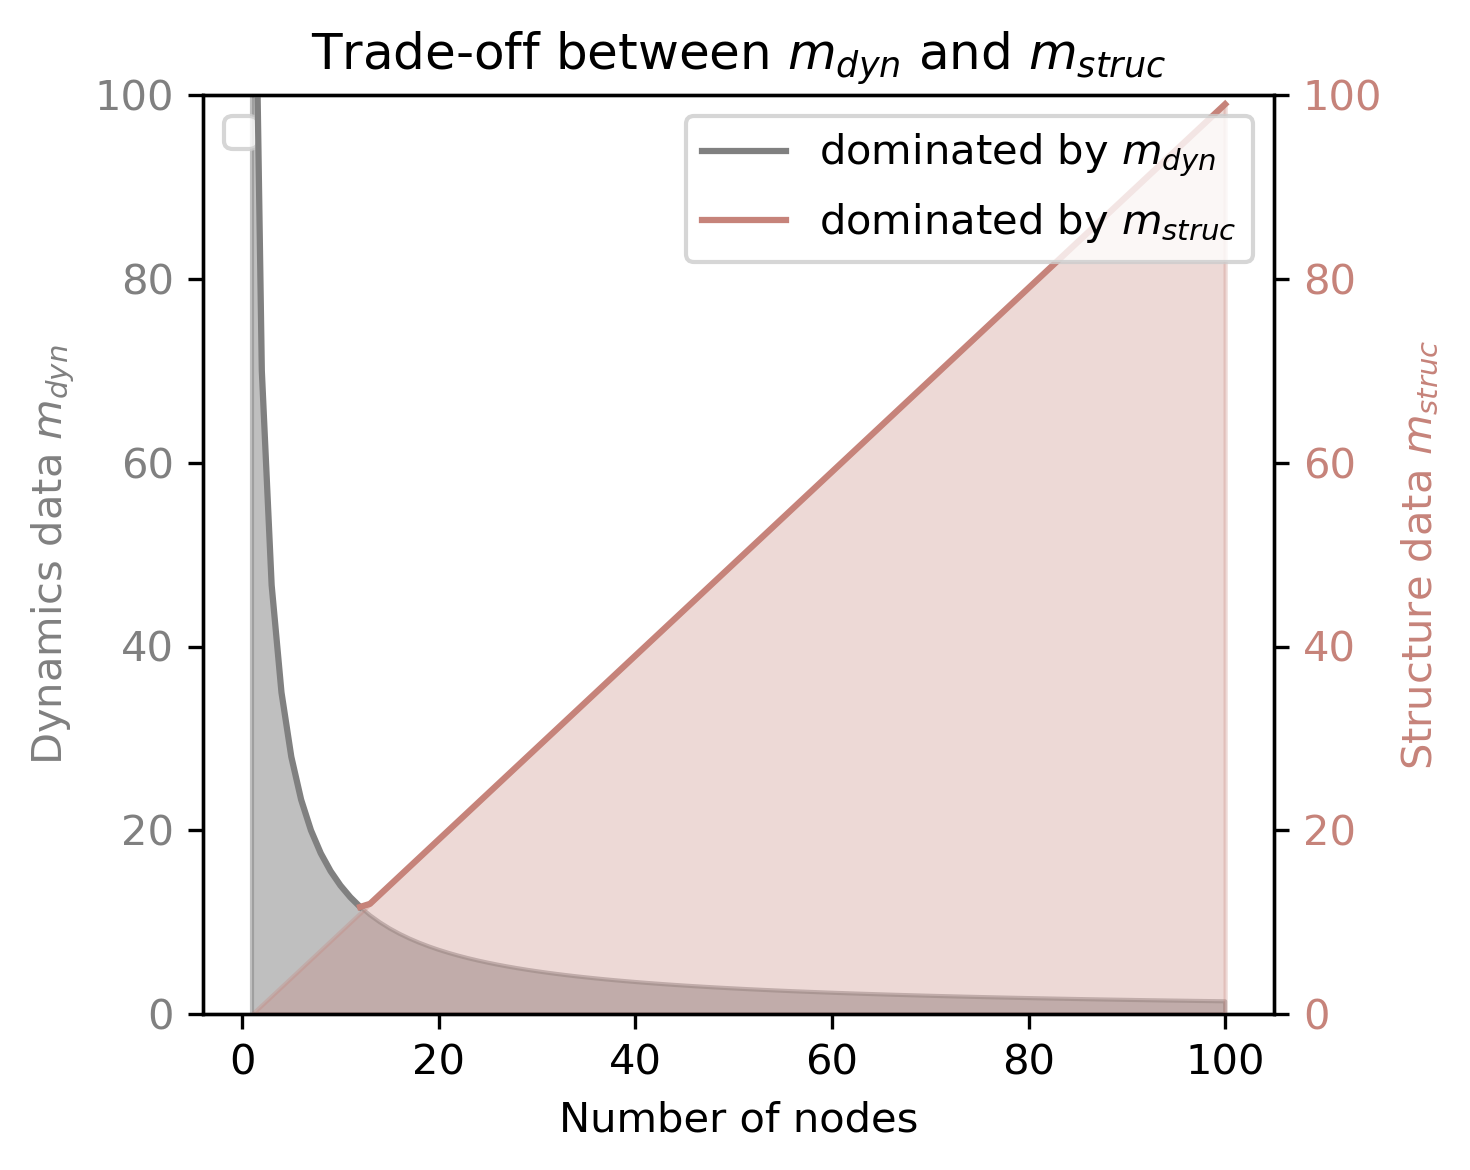

In [3]:
plt.rcParams['figure.dpi'] = 300
fig, ax1 = plt.subplots(figsize=(5,4))
idx = np.argwhere(np.diff(np.sign(mdyn - mstruc))).flatten()
print(idx)

# ax1.plot(N, mdyn, 'g-', label='Dynamics')
# ax1.fill_between(N, 0, mdyn, color='#90501E', alpha=0.3)
ax1.fill_between(N, 0, mdyn, color='gray', alpha=0.5)
ax1.set_xlabel('Number of nodes')   
ax1.set_ylabel('Dynamics data $m_{dyn}$', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.set_ylim(0, 100)

ax2 = ax1.twinx()
# ax2.plot(N, mstruc, 'b-', label='Structure')
# ax2.fill_between(N, 0, mstruc, color='#320C58', alpha=0.3) 
ax2.fill_between(N, 0, mstruc, color='#C6837A', alpha=0.3)
ax2.set_ylabel('Structure data $m_{struc}$', color='#C6837A')
ax2.tick_params(axis='y', labelcolor='#C6837A')

left_upper = np.maximum(mdyn[:idx[0]+1], mstruc[:idx[0]+1])
right_upper = np.maximum(mdyn[idx[0]:], mstruc[idx[0]:])
ax2.plot(N[:idx[0]+1], left_upper, color = 'gray', label='dominated by $m_{dyn}$') 
ax2.plot(N[idx[0]:], right_upper, color = '#C6837A', label='dominated by $m_{struc}$')
ax2.set_ylim(0, 100)

plt.title('Trade-off between $m_{dyn}$ and $m_{struc}$')   
fig.tight_layout()


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# plt.savefig('simul_batch5/datatradeoff_color_grayred_c140.pdf') 

In [85]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snb
from torch.functional import F
import torch
from sklearn.metrics import average_precision_score

Time = 40
delt_t = 0.001
epochs = 3000
Nodes = 5
lam = 0.1
Degree = 2
exp_ind = [1,2,3,4,5]
edges = int(Degree*Nodes)

In [5]:
import glob

def load_all(resu_prefix, epc):
    loss_file = glob.glob(resu_prefix + 'loss_over_time_lam*.pkl')
    for name in loss_file:
        with open(name, 'rb') as f:
            Loss = pickle.load(f)
    with open(resu_prefix + f'weights_over_time_lam{lam}_e{epc-1}.pkl', 'rb') as f:
        weights = pickle.load(f)
    eva_file = glob.glob(resu_prefix + f'Eva_lam*_e{epc-1}.csv')
    for name in eva_file:
        Eva = pd.read_csv(name)
    return Loss[epc-epochs-1], weights[-1], Eva.iloc[-1,1], Eva.iloc[-1,2]
    return Loss[epc-epochs-1], val_loss[epc-epochs-1], weights[-1], Eva.iloc[-1,1], Eva.iloc[-1,2]


In [6]:
def load_and_append(resu, epc, loss_over_time, val_loss_over_time, weights_over_time, auc_over_time, auprc_over_time):
    # loss, val_loss, weights, auc, auprc = load_all(resu, epc)
    loss, weights, auc, auprc = load_all(resu, epc)
    loss_over_time.append(loss)
    # val_loss_over_time.append(val_loss)
    weights_over_time.append(weights)
    auc_over_time.append(auc)
    auprc_over_time.append(auprc)

In [7]:
import torch
from torch.functional import F
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import root_scalar

def weights2Bi(weights_over_time, threshold):
    weights_ind = torch.tensor(weights_over_time)
    Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
    Gweights = Gweights[:,0].view(-1,1)
    Gweights.cpu
    bestWei = Gweights.detach().numpy()

    bi_bestWei = np.where(bestWei<threshold, 0, 1) # 0 or 1 for each edge
    bi_Stru = np.zeros((nodes_num, nodes_num))
    mask = np.ones((nodes_num, nodes_num), dtype=bool)
    np.fill_diagonal(mask, 0)
    bi_Stru[mask] = bi_bestWei.squeeze()
    return bi_Stru.T

def MixGaussian(bestWei, nc = 2, fc=0.005): # threshold value for binary structure
    filtered_weights = bestWei[bestWei >= fc] # remove small weights, avoid unbalanced disctirbution
    filtered_weights = filtered_weights.reshape(-1,1)
    gmm = GaussianMixture(n_components=nc, random_state=0)
    gmm.fit(filtered_weights)
    weights = gmm.weights_
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()

    def Two_Gaussian(x):
        return weights[0] * norm.pdf(x, means[0], np.sqrt(variances[0])) - weights[1] * norm.pdf(x, means[1], np.sqrt(variances[1]))

    def Three_Gaussian(x):
        return weights[1] * norm.pdf(x, means[1], np.sqrt(variances[1])) - weights[2] * norm.pdf(x, means[2], np.sqrt(variances[2]))
    
    def check_signs(f, a, b):
        fa = f(a)
        fb = f(b)
        return np.sign(fa) != np.sign(fb)

    if nc ==2:
        if check_signs(Two_Gaussian, min(means), max(means)):
            root_result = root_scalar(Two_Gaussian, method='brentq', bracket=[min(means), max(means)])
            return root_result.root
        else:
            return False
    elif nc ==3:
        if check_signs(Three_Gaussian, min(means), max(means)):
            root_result = root_scalar(Three_Gaussian, method='brentq', bracket=[min(means), max(means)])
            return root_result.root
        else:
            return False

def Gauweights2Bi(weights_over_time, Gau=True, fc=0.005):
    weights_ind = torch.tensor(weights_over_time)
    Gweights = F.softmax(weights_ind/(0.999**epc),dim=1)
    Gweights = Gweights[:,0].view(-1,1)
    Gweights.cpu
    bestWei = Gweights.detach().numpy()
    if Gau:
        threshold_tmp = MixGaussian(bestWei,fc=fc)
        if threshold_tmp == False:
            threshold = 0.5
        # elif threshold_tmp < 0.04:
        #     threshold = 0.5
        # elif threshold_tmp > 0.8:
        #     threshold = 0.5
        else:
            threshold = threshold_tmp
    else:
        threshold = 0.5
    bi_bestWei = np.where(bestWei<threshold, 0, 1) # 0 or 1 for each edge
    bi_Stru = np.zeros((nodes_num, nodes_num))
    mask = np.ones((nodes_num, nodes_num), dtype=bool)
    np.fill_diagonal(mask, 0)
    bi_Stru[mask] = bi_bestWei.squeeze()
    return bi_Stru.T

def cal_fro_error(objectAij,infer_struc):
    error = np.linalg.norm(objectAij - infer_struc, 'fro')/np.linalg.norm(objectAij, 'fro')
    return error

def cal_new_error(objectAij,infer_struc):
    error = np.sum(np.abs(objectAij-infer_struc))/(objectAij.shape[0]*(objectAij.shape[0]-1))
    return error

def struc_error(objectAij,infer_struc):
    error = np.sum(np.abs(objectAij-infer_struc))/np.sum(np.abs(objectAij))
    return error

In [8]:
hidden = 50

In [9]:
M1 = np.arange(5,99,2)
M = M1.tolist()
M.append(100) 
M5 = M
M10 = M  
M15 = M
M20 = M
M50 = M
m = np.arange(0.1,3.1,0.1)
m = m.tolist()
M100 = [int(m[i]*100) for i in range(len(m))]

In [ ]:
epc = 2800
Nodes = 5
loss_over_time = []
val_loss_over_time = []
weights_over_time = []
auc_over_time = []
auprc_over_time = []

M5 = M
for inx in exp_ind:
    for t in range(len(M5)):
        m = M5[t]
        resu = f'simul_infer/Nodes{Nodes}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        load_and_append(resu, epc, loss_over_time, val_loss_over_time, weights_over_time, auc_over_time, auprc_over_time)

In [ ]:
from sklearn.metrics import average_precision_score

with open('data/Series_N5_M10_T50_ind1.pickle','rb') as f:
    objectAij,series = pickle.load(f)

nodes_num = Nodes
Binary_infer_struc5 = []
Bi_auprc5 = []
error5 = []

for ii in range(len(M5)*len(exp_ind)):
    threshold = 0.05
    bi_Stru = weights2Bi(weights_over_time[ii], threshold)
    bi_aupr = average_precision_score(objectAij.reshape(-1,1), bi_Stru.reshape(-1,1))
    Binary_infer_struc5.append(bi_Stru)
    Bi_auprc5.append(bi_aupr)
    error5.append(struc_error(objectAij,bi_Stru))

In [ ]:
epc = 2800
Nodes = 10
loss_over_time = []
val_loss_over_time = []
weights_over_time = []
auc_over_time = []
auprc_over_time = []

M10 = M
for inx in exp_ind:
    for t in range(len(M10)):
        m = M10[t]
        resu = f'simul_infer/Nodes{Nodes}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        load_and_append(resu, epc, loss_over_time, val_loss_over_time, weights_over_time, auc_over_time, auprc_over_time)

In [ ]:
from sklearn.metrics import average_precision_score

with open('data/Series_N10_M20_T50_ind1.pickle','rb') as f:
    objectAij,series = pickle.load(f)

nodes_num = Nodes
Binary_infer_struc10 = []
Bi_auprc10 = []
error10 = []

for ii in range(len(M10)*len(exp_ind)):
    bi_Stru = Gauweights2Bi(weights_over_time[ii], fc=0.00001)
    bi_aupr = average_precision_score(objectAij.reshape(-1,1), bi_Stru.reshape(-1,1))
    Binary_infer_struc10.append(bi_Stru)
    Bi_auprc10.append(bi_aupr)
    error10.append(struc_error(objectAij,bi_Stru))

In [ ]:
epc = 2800
Nodes = 15
loss_over_time = []
val_loss_over_time = []
weights_over_time = []
auc_over_time = []
auprc_over_time = []

M15 = M
for inx in exp_ind:
    for t in range(len(M15)):
        m = M15[t]
        resu = f'simul_infer/Nodes{Nodes}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        load_and_append(resu, epc, loss_over_time, val_loss_over_time, weights_over_time, auc_over_time, auprc_over_time)

In [ ]:
from sklearn.metrics import average_precision_score

with open('data/Series_N15_M30_T50_ind1.pickle','rb') as f:
    objectAij,series = pickle.load(f)

nodes_num = Nodes
Binary_infer_struc15 = []
Bi_auprc15 = []
error15 = []

for ii in range(len(M15)*len(exp_ind)):
    bi_Stru = Gauweights2Bi(weights_over_time[ii],fc=0.00001)
    bi_aupr = average_precision_score(objectAij.reshape(-1,1), bi_Stru.reshape(-1,1))
    Binary_infer_struc15.append(bi_Stru)
    Bi_auprc15.append(bi_aupr)
    error15.append(struc_error(objectAij,bi_Stru))

In [ ]:
epc = 2800
Nodes = 20
loss_over_time = []
val_loss_over_time = []
weights_over_time = []
auc_over_time = []
auprc_over_time = []

M20 = M
for inx in exp_ind:
    for t in range(len(M20)):
        m = M20[t]
        resu = f'simul_infer/Nodes{Nodes}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        load_and_append(resu, epc, loss_over_time, val_loss_over_time, weights_over_time, auc_over_time, auprc_over_time)

In [ ]:
from sklearn.metrics import average_precision_score

with open('data/Series_N20_M40_T50_ind1.pickle','rb') as f:
    objectAij,series = pickle.load(f)

nodes_num = Nodes
Binary_infer_struc20 = []
Bi_auprc20 = []
error20 = []

for ii in range(len(M20)*len(exp_ind)):
    bi_Stru = Gauweights2Bi(weights_over_time[ii],fc = 0.00001)
    bi_aupr = average_precision_score(objectAij.reshape(-1,1), bi_Stru.reshape(-1,1))
    Binary_infer_struc20.append(bi_Stru)
    Bi_auprc20.append(bi_aupr)
    error20.append(struc_error(objectAij,bi_Stru))

In [ ]:
epc = 2800
Nodes = 50
loss_over_time = []
val_loss_over_time = []
weights_over_time = []
auc_over_time = []
auprc_over_time = []

for ind in exp_ind:
    for t in range(len(M50)):
        m = M50[t]
        resu = f'simul_infer/Nodes{Nodes}_Times40_m{m}_hidden{hidden}_exp{ind}/'
        load_and_append(resu, epc, loss_over_time, val_loss_over_time, weights_over_time, auc_over_time, auprc_over_time)

In [ ]:
from sklearn.metrics import average_precision_score

with open('data/Series_N50_M500_T100_ind1.pickle','rb') as f:
    objectAij,series = pickle.load(f)

nodes_num = Nodes
Binary_infer_struc50 = []
Bi_auprc50 = []
error50 = []

for ii in range(len(M50)*len(exp_ind)):
    bi_Stru = Gauweights2Bi(weights_over_time[ii],fc=0.00001)
    bi_aupr = average_precision_score(objectAij.reshape(-1,1), bi_Stru.reshape(-1,1))
    Binary_infer_struc50.append(bi_Stru)
    Bi_auprc50.append(bi_aupr)
    error50.append(struc_error(objectAij,bi_Stru))

In [ ]:
exp_ind = [1,2,3,4,5]
epc = 2800
Nodes = 100
loss_over_time = []
val_loss_over_time = []
weights_over_time = []
auc_over_time = []
auprc_over_time = []

for ind in exp_ind:
    for t in range(len(M100)):
        m = M100[t]
        resu = f'simul_infer/Nodes{Nodes}_Times40_m{m}_hidden{hidden}_exp{ind}/'
        load_and_append(resu, epc, loss_over_time, val_loss_over_time, weights_over_time, auc_over_time, auprc_over_time)

from sklearn.metrics import average_precision_score
with open('data/Series_N100_M1000_T100_ind1.pickle','rb') as f:
    objectAij,series = pickle.load(f)

nodes_num = Nodes
Binary_infer_struc100 = []
Bi_auprc100 = []
error100 = []

for ii in range(len(M100)*len(exp_ind)):
    bi_Stru = Gauweights2Bi(weights_over_time[ii],fc=0.00001)
    bi_aupr = average_precision_score(objectAij.reshape(-1,1), bi_Stru.reshape(-1,1))
    Binary_infer_struc100.append(bi_Stru)
    Bi_auprc100.append(bi_aupr)
    error100.append(struc_error(objectAij,bi_Stru))

In [25]:
def reshape_norm(error):
    error = np.array(error)
    error = error.reshape(len(exp_ind),-1)
    return error

values = [5,10,15,20,50,100]
name_vars = ['error']

results = {}

for value in values:
    for var in name_vars:
        error_var = f'{var}{value}'
        results[error_var] = reshape_norm(globals()[error_var])
        results[f'{var}mean{value}'] = np.mean(results[error_var], axis=0)
        results[f'{var}std{value}'] = np.std(results[error_var], axis=0)

#### dynamics error 

In [ ]:
import sys
sys.path.append('../')
import pickle
from utils.tools import *
from utils.model import *
from torch_geometric.data import DataLoader, Batch

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

def collate_data_list(data_list):
    return Batch.from_data_list(data_list)

def pack_data(nodes_num, test_num, degree=2):

    if degree == 2:
        Times = 50
    if degree == 10:
        Times = 100
        
    edges = int(degree*nodes_num)
    path = f'./data/Series_N{nodes_num}_M{edges}_T{Times}_ind1.pickle'
    with open(path, 'rb') as f:
        objectAij, data= pickle.load(f)

    Dimension = int(data.shape[1]/nodes_num)
    dt = 0.001
    tponits = int(Times/dt)
    data = data.reshape(tponits, nodes_num, Dimension)
    series = data[int(40/0.001):tponits,:,:] #second 20% uses as test data

    # use 4-Order diff to fit
    timeseries_ft2 = series[4:,:,:]
    timeseries_ft1 = series[3:-1,:,:]
    timeseries_bt1 = series[1:-3,:,:]
    timeseries_bt2 = series[0:-4,:,:]
    dXdt = (-timeseries_ft2+8*timeseries_ft1-8*timeseries_bt1+timeseries_bt2)/(12*dt)
    timeseries = series[2:-2,:,:]
    print(dXdt.shape==timeseries.shape)

    mapping_data = timeseries
    goal_data = dXdt

    X = torch.as_tensor(np.array(mapping_data).astype('float'))
    y = torch.as_tensor(np.array(goal_data).astype('float'))

    np.random.seed(2042)

    initialA = np.ones((nodes_num,nodes_num)) # fully connected
    np.fill_diagonal(initialA,0) # delete diagonal links
    edge_index = get_edge_index(initialA)

    X_test = X.float()
    y_test = y.float()

    # data
    test_idxes = np.random.randint(0, len(X_test), test_num)
    newtestloader = DataLoader(
        [Data(
            X_test[i],
            edge_index=edge_index,
            y=y_test[i]) for i in test_idxes],
        batch_size=len(X_test),
        shuffle=False)

    newtestloader = DataLoader(newtestloader.dataset, batch_size=len(X_test), collate_fn=collate_data_list, shuffle=False)
    return newtestloader, objectAij

In [ ]:
def get_messages_with_trueAij(tDyn, dim, loader, objectAij, device, msg_dim=1,epc=2800):

    def get_message_info(tmp):
        tDyn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] #source
        s1 = s1[:,0]
        s2 = tmp.x[tmp.edge_index[1]] #target
        s2 = s2[:,0]
        Tmp = torch.cat([s2, s1]) # tmp --> xi,xj
        Tmp = Tmp.reshape(2,-1)
        Tmp = Tmp.t()

        Gweights = F.softmax(tDyn.weights/(0.999**epc),dim=1)
        Gweights = Gweights[:,0].view(-1,1)
        Len = int(s1.shape[0])/int(Gweights.shape[0])
        w = Gweights.repeat(int(Len),1)
        tmpW = torch.cat([Tmp,w],dim=1)
        tmpW = tmpW.to(torch.float32)
        Gxixj = tDyn.msg_fnc(Tmp)
        m12 = Gxixj*w #/source_x[:,Dimension].reshape(source_x.shape[0],1)

        nodes_num = int(objectAij.shape[0])
        mask = np.ones((nodes_num, nodes_num), dtype=bool)
        np.fill_diagonal(mask, 0)
        selected_elements = objectAij.T[mask]
        object_edges_rem_diag = selected_elements.reshape(-1,1)
        object_edges = np.tile(object_edges_rem_diag, (int(Len), 1))
        object_edges = torch.tensor(object_edges, dtype=torch.float32)
        object_edges = object_edges.view(-1,1)

        all_messages = torch.cat((
            tmpW, object_edges, Gxixj,
             m12), dim=1)
        if dim == 1:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['w']
            columns += ['Aij']
            columns += ['G']
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['w']
            columns += ['Aij']
            columns += ['G']
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['w']
            columns += ['Aij']
            columns += ['G']
            columns += ['e%d'%(k,) for k in range(msg_dim)]

        return pd.DataFrame(
              data=all_messages.cpu().detach().numpy(),
             columns=columns
        )
        #print(all_messages.shape)
        return pd.DataFrame(all_messages)

    msg_info = []
    for i, g in enumerate(loader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    
    return msg_info

In [ ]:
def self_message_error(data_path, Dyn,epc):
    recorded_models = torch.load(data_path+f'recorded_models_lam{lam}_e{epc-1}.pt',map_location=device, weights_only=True)
    Dyn.load_state_dict(recorded_models[-1])
    # cur_msgs = get_interaction(Dyn, dim=3, msg_dim=1, loader=newtestloader, device=device)
    cur_msgs = get_messages_with_trueAij(Dyn,dim=3,loader=newtestloader,objectAij=objectAij,device=device,epc = epc) 
    cur_selfdyn = get_selfDynamics(Dyn, dim=3, loader=newtestloader, device=device)

    bestMe = cur_msgs[['x1','x2','Aij','G','e0']]    
    x_j = bestMe['x2'].values
    x_i = bestMe['x1'].values
    G_value = 0.2*(x_j-x_i)
    temp = bestMe.iloc[:,-2].values # G(xi,xj)
    msg_error_G = 1-(np.corrcoef(G_value,temp)[0,1])**2
    coup_value = G_value*bestMe['Aij'].values
    temp = bestMe.iloc[:,-1].values # A*G(xi,xj)
    msg_error_I = 1-(np.corrcoef(coup_value,temp)[0,1])**2

    best_selfDyn = cur_selfdyn
    sx = best_selfDyn['s1'].values
    sx_true = -10*best_selfDyn['x']+10*best_selfDyn['y']
    sy = best_selfDyn['s2'].values
    sy_true = 28*best_selfDyn['x']-best_selfDyn['y']-best_selfDyn['x']*best_selfDyn['z']
    sz = best_selfDyn['s3'].values
    sz_true = -8/3*best_selfDyn['z']+best_selfDyn['x']*best_selfDyn['y']
    self_dim1_error = 1-(np.corrcoef(sx_true,sx)[0,1])**2
    self_dim2_error = 1-(np.corrcoef(sy_true,sy)[0,1])**2
    self_dim3_error = 1-(np.corrcoef(sz_true,sz)[0,1])**2
    best_error_G = max(self_dim1_error,self_dim2_error,self_dim3_error,msg_error_G)
    best_error_I = max(self_dim1_error,self_dim2_error,self_dim3_error,msg_error_I)
    return msg_error_G, msg_error_I, self_dim1_error, self_dim2_error, self_dim3_error,best_error_G, best_error_I


In [22]:
# np.random.seed(20)
n_f = 3
msg_dim = 1
Dimension = 3
dim = 3
tau = 1
aggr = 'add'
dt = 0.001
ind = [1,2,3,4,5]
hidden = 50
epc = 2800

In [ ]:
hidden = 50
nodes_num = 5
edge_num = nodes_num*(nodes_num-1)
Gerror5 = []
Ierror5 = []
F_dim1_error5 = []
F_dim2_error5 = []
F_dim3_error5 = []
max_G_error5 = []
max_I_error5 = []
newtestloader,objectAij = pack_data(nodes_num, 1000, degree=2)
Dyn = simultaneous_infer_deriv(n_f, msg_dim, dim, dt, edge_num, tau=tau, lam=lam, aggr=aggr, hidden=hidden).to(device)
for inx in ind:
    for t in range(len(M5)):
        m = M5[t]
        data_path = f'simul_infer/Nodes{nodes_num}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        cur_msg_G_error, cur_msg_I_error, cur_dim1_error, cur_dim2_error,cur_dim3_error, cur_maxG_error, cur_maxI_error = self_message_error(data_path,Dyn,epc)
        Gerror5.append(cur_msg_G_error)
        Ierror5.append(cur_msg_I_error)
        max_G_error5.append(cur_maxG_error)
        max_I_error5.append(cur_maxI_error)
        F_dim1_error5.append(cur_dim1_error)
        F_dim2_error5.append(cur_dim2_error)
        F_dim3_error5.append(cur_dim3_error)
print(len(Gerror5))

True


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


240


In [ ]:
with open(f'simul_infer/simul_Dynerror5_Rerrormax.pkl', 'wb') as f:
    pickle.dump([M5,Gerror5,Ierror5,F_dim1_error5,F_dim2_error5,F_dim3_error5,max_G_error5,max_I_error5], f)

In [ ]:
hidden = 50
nodes_num = 10
edge_num = nodes_num*(nodes_num-1)

Gerror10 = []
Ierror10 = []
F_dim1_error10 = []
F_dim2_error10 = []
F_dim3_error10 = []
max_G_error10 = []
max_I_error10 = []
newtestloader,objectAij = pack_data(nodes_num, 1000, degree=2)
Dyn = simultaneous_infer_deriv(n_f, msg_dim, dim, dt, edge_num, tau=tau, lam=lam, aggr=aggr, hidden=hidden).to(device)
for inx in ind:
    for t in range(len(M10)):
        m = M10[t]
        data_path = f'simul_infer/Nodes{nodes_num}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        cur_msg_G_error, cur_msg_I_error, cur_dim1_error, cur_dim2_error,cur_dim3_error, cur_maxG_error, cur_maxI_error = self_message_error(data_path,Dyn,epc)
        Gerror10.append(cur_msg_G_error)
        Ierror10.append(cur_msg_I_error)
        max_G_error10.append(cur_maxG_error)
        max_I_error10.append(cur_maxI_error)
        F_dim1_error10.append(cur_dim1_error)
        F_dim2_error10.append(cur_dim2_error)
        F_dim3_error10.append(cur_dim3_error)

print(len(Gerror10))
with open(f'simul_infer/simul_Dynerror10_Rerrormax.pkl', 'wb') as f:
    pickle.dump([M10,Gerror10,Ierror10,F_dim1_error10,F_dim2_error10,F_dim3_error10,max_G_error10,max_I_error10], f)

True


240


In [ ]:
hidden = 50
nodes_num = 15
edge_num = nodes_num*(nodes_num-1)
Gerror15 = []
Ierror15 = []
F_dim1_error15 = []
F_dim2_error15 = []
F_dim3_error15 = []
max_G_error15 = []
max_I_error15 = []
newtestloader,objectAij = pack_data(nodes_num, 1000, degree=2)
Dyn = simultaneous_infer_deriv(n_f, msg_dim, dim, dt, edge_num, tau=tau, lam=lam, aggr=aggr, hidden=hidden).to(device)
for inx in ind:
    for t in range(len(M15)):
        m = M15[t]
        data_path = f'simul_infer/Nodes{nodes_num}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        cur_msg_G_error, cur_msg_I_error, cur_dim1_error, cur_dim2_error,cur_dim3_error, cur_maxG_error, cur_maxI_error = self_message_error(data_path,Dyn,epc)
        Gerror15.append(cur_msg_G_error)
        Ierror15.append(cur_msg_I_error)
        max_G_error15.append(cur_maxG_error)
        max_I_error15.append(cur_maxI_error)
        F_dim1_error15.append(cur_dim1_error)
        F_dim2_error15.append(cur_dim2_error)
        F_dim3_error15.append(cur_dim3_error)

print(len(Gerror15))
with open(f'simul_infer/simul_Dynerror15_Rerrormax.pkl', 'wb') as f:
    pickle.dump([M15,Gerror15,Ierror15,F_dim1_error15,F_dim2_error15,F_dim3_error15,max_G_error15,max_I_error15], f)    

True


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


240


In [ ]:
hidden = 50
nodes_num = 50
edge_num = nodes_num*(nodes_num-1)

epc = 2800
Gerror50 = []
Ierror50 = []
F_dim1_error50 = []
F_dim2_error50 = []
F_dim3_error50 = []
max_G_error50 = []
max_I_error50 = []
newtestloader,objectAij = pack_data(nodes_num, 1000, degree=10)
Dyn = simultaneous_infer_deriv(n_f, msg_dim, dim, dt, edge_num, tau=tau, lam=lam, aggr=aggr, hidden=hidden).to(device)
for inx in ind:
    for t in range(len(M50)):
        m = M50[t]
        data_path = f'simul_infer/Nodes{nodes_num}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        cur_msg_G_error, cur_msg_I_error, cur_dim1_error, cur_dim2_error,cur_dim3_error, cur_maxG_error, cur_maxI_error = self_message_error(data_path,Dyn,epc)
        Gerror50.append(cur_msg_G_error)
        Ierror50.append(cur_msg_I_error)
        max_G_error50.append(cur_maxG_error)
        max_I_error50.append(cur_maxI_error)
        F_dim1_error50.append(cur_dim1_error)
        F_dim2_error50.append(cur_dim2_error)
        F_dim3_error50.append(cur_dim3_error)

print(len(Gerror50))
with open(f'simul_infer/simul_Dynerror50_Rerrormax.pkl', 'wb') as f:
    pickle.dump([M50,Gerror50,Ierror50,F_dim1_error50,F_dim2_error50,F_dim3_error50,max_G_error50,max_I_error50], f)

In [ ]:
hidden = 50
nodes_num = 20
edge_num = nodes_num*(nodes_num-1)
epc = 2800
Gerror20 = []
Ierror20 = []
F_dim1_error20 = []
F_dim2_error20 = []
F_dim3_error20 = []
max_G_error20 = []
max_I_error20 = []
newtestloader,objectAij = pack_data(nodes_num, 1000, degree=2)
Dyn = simultaneous_infer_deriv(n_f, msg_dim, dim, dt, edge_num, tau=tau, lam=lam, aggr=aggr, hidden=hidden).to(device)
for inx in ind:
    for t in range(len(M20)):
        m = M20[t]
        data_path = f'simul_infer/Nodes{nodes_num}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        cur_msg_G_error, cur_msg_I_error, cur_dim1_error, cur_dim2_error,cur_dim3_error, cur_maxG_error, cur_maxI_error = self_message_error(data_path,Dyn,epc)
        Gerror20.append(cur_msg_G_error)
        Ierror20.append(cur_msg_I_error)
        max_G_error20.append(cur_maxG_error)
        max_I_error20.append(cur_maxI_error)
        F_dim1_error20.append(cur_dim1_error)
        F_dim2_error20.append(cur_dim2_error)
        F_dim3_error20.append(cur_dim3_error)

print(len(Gerror20))
with open(f'simul_infer/simul_Dynerror20_Rerrormax.pkl', 'wb') as f:
    pickle.dump([M20,Gerror20,Ierror20,F_dim1_error20,F_dim2_error20,F_dim3_error20,max_G_error20,max_I_error20], f)

True


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


240


In [ ]:
hidden = 50
nodes_num = 100
edge_num = nodes_num*(nodes_num-1)
epc = 2800

Gerror100 = []
Ierror100 = []
F_dim1_error100 = []
F_dim2_error100 = []
F_dim3_error100 = []
max_G_error100 = []
max_I_error100 = []
newtestloader,objectAij = pack_data(nodes_num, 1000, degree=10)
Dyn = simultaneous_infer_deriv(n_f, msg_dim, dim, dt, edge_num, tau=tau, lam=lam, aggr=aggr, hidden=hidden).to(device)
for inx in ind:
    for t in range(len(M100)):
        m = M100[t]
        data_path = f'simul_infer/Nodes{nodes_num}_Times40_m{m}_hidden{hidden}_exp{inx}/'
        cur_msg_G_error, cur_msg_I_error, cur_dim1_error, cur_dim2_error,cur_dim3_error, cur_maxG_error, cur_maxI_error = self_message_error(data_path,Dyn,epc)
        Gerror100.append(cur_msg_G_error)
        Ierror100.append(cur_msg_I_error)
        max_G_error100.append(cur_maxG_error)
        max_I_error100.append(cur_maxI_error)
        F_dim1_error100.append(cur_dim1_error)
        F_dim2_error100.append(cur_dim2_error)
        F_dim3_error100.append(cur_dim3_error)

print(len(Gerror100))
with open(f'simul_infer/simul_Dynerror100_Rerrormax.pkl', 'wb') as f:
    pickle.dump([M100,Gerror100,Ierror100,F_dim1_error100,F_dim2_error100,F_dim3_error100,max_G_error100,max_I_error100], f)

True


/home/sunyiting2/anaconda3/envs/py310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


dynamics error as max of R-square 

In [ ]:
with open(f'simul_infer/simul_Dynerror100_Rerrormax.pkl', 'rb') as f:
    M100,Gerror100,Ierror100,F_dim1_error100,F_dim2_error100,F_dim3_error100,max_G_error100,max_I_error100 = pickle.load(f)
with open(f'simul_infer/simul_Dynerror50_Rerrormax.pkl', 'rb') as f:
    M50,Gerror50,Ierror50,F_dim1_error50,F_dim2_error50,F_dim3_error50,max_G_error50,max_I_error50 = pickle.load(f)
with open(f'simul_infer/simul_Dynerror20_Rerrormax.pkl', 'rb') as f:
    M20,Gerror20,Ierror20,F_dim1_error20,F_dim2_error20,F_dim3_error20,max_G_error20,max_I_error20 = pickle.load(f)
with open(f'simul_infer/simul_Dynerror15_Rerrormax.pkl', 'rb') as f:
    M15,Gerror15,Ierror15,F_dim1_error15,F_dim2_error15,F_dim3_error15,max_G_error15,max_I_error15 = pickle.load(f)
with open(f'simul_infer/simul_Dynerror10_Rerrormax.pkl', 'rb') as f:
    M10,Gerror10,Ierror10,F_dim1_error10,F_dim2_error10,F_dim3_error10,max_G_error10,max_I_error10 = pickle.load(f)
with open(f'simul_infer/simul_Dynerror5_Rerrormax.pkl', 'rb') as f:
    M5,Gerror5,Ierror5,F_dim1_error5,F_dim2_error5,F_dim3_error5,max_G_error5,max_I_error5 = pickle.load(f)

In [77]:
# dynamics error
preError5 = max_G_error5
preError10 = max_G_error10
preError15 = max_G_error15
preError20 = max_G_error20
preError50 = max_G_error50
preError100 = max_G_error100

In [35]:
# structure and dynamcis errors (concatenate)
preError5 = max_I_error5
preError10 = max_I_error10
preError15 = max_I_error15
preError20 = max_I_error20
preError50 = max_I_error50
preError100 = max_I_error100

In [78]:
ind = [1,2,3,4,5]
def reshape_norm(Matrix):
    exp = len(ind)
    reshape_matrix = np.array(Matrix).reshape(exp,-1)
    return reshape_matrix

In [79]:
values = [5,10,15,20,50,100]
name_vars = ['preError']

errorall = {}

for value in values:
    for var in name_vars:
        error_var = f'{var}{value}'
        errorall[error_var] = reshape_norm(globals()[error_var])
        # maen and std save in dict 
        errorall[f'{var}mean{value}'] = np.mean(errorall[error_var], axis=0)
        errorall[f'{var}std{value}'] = np.std(errorall[error_var], axis=0)

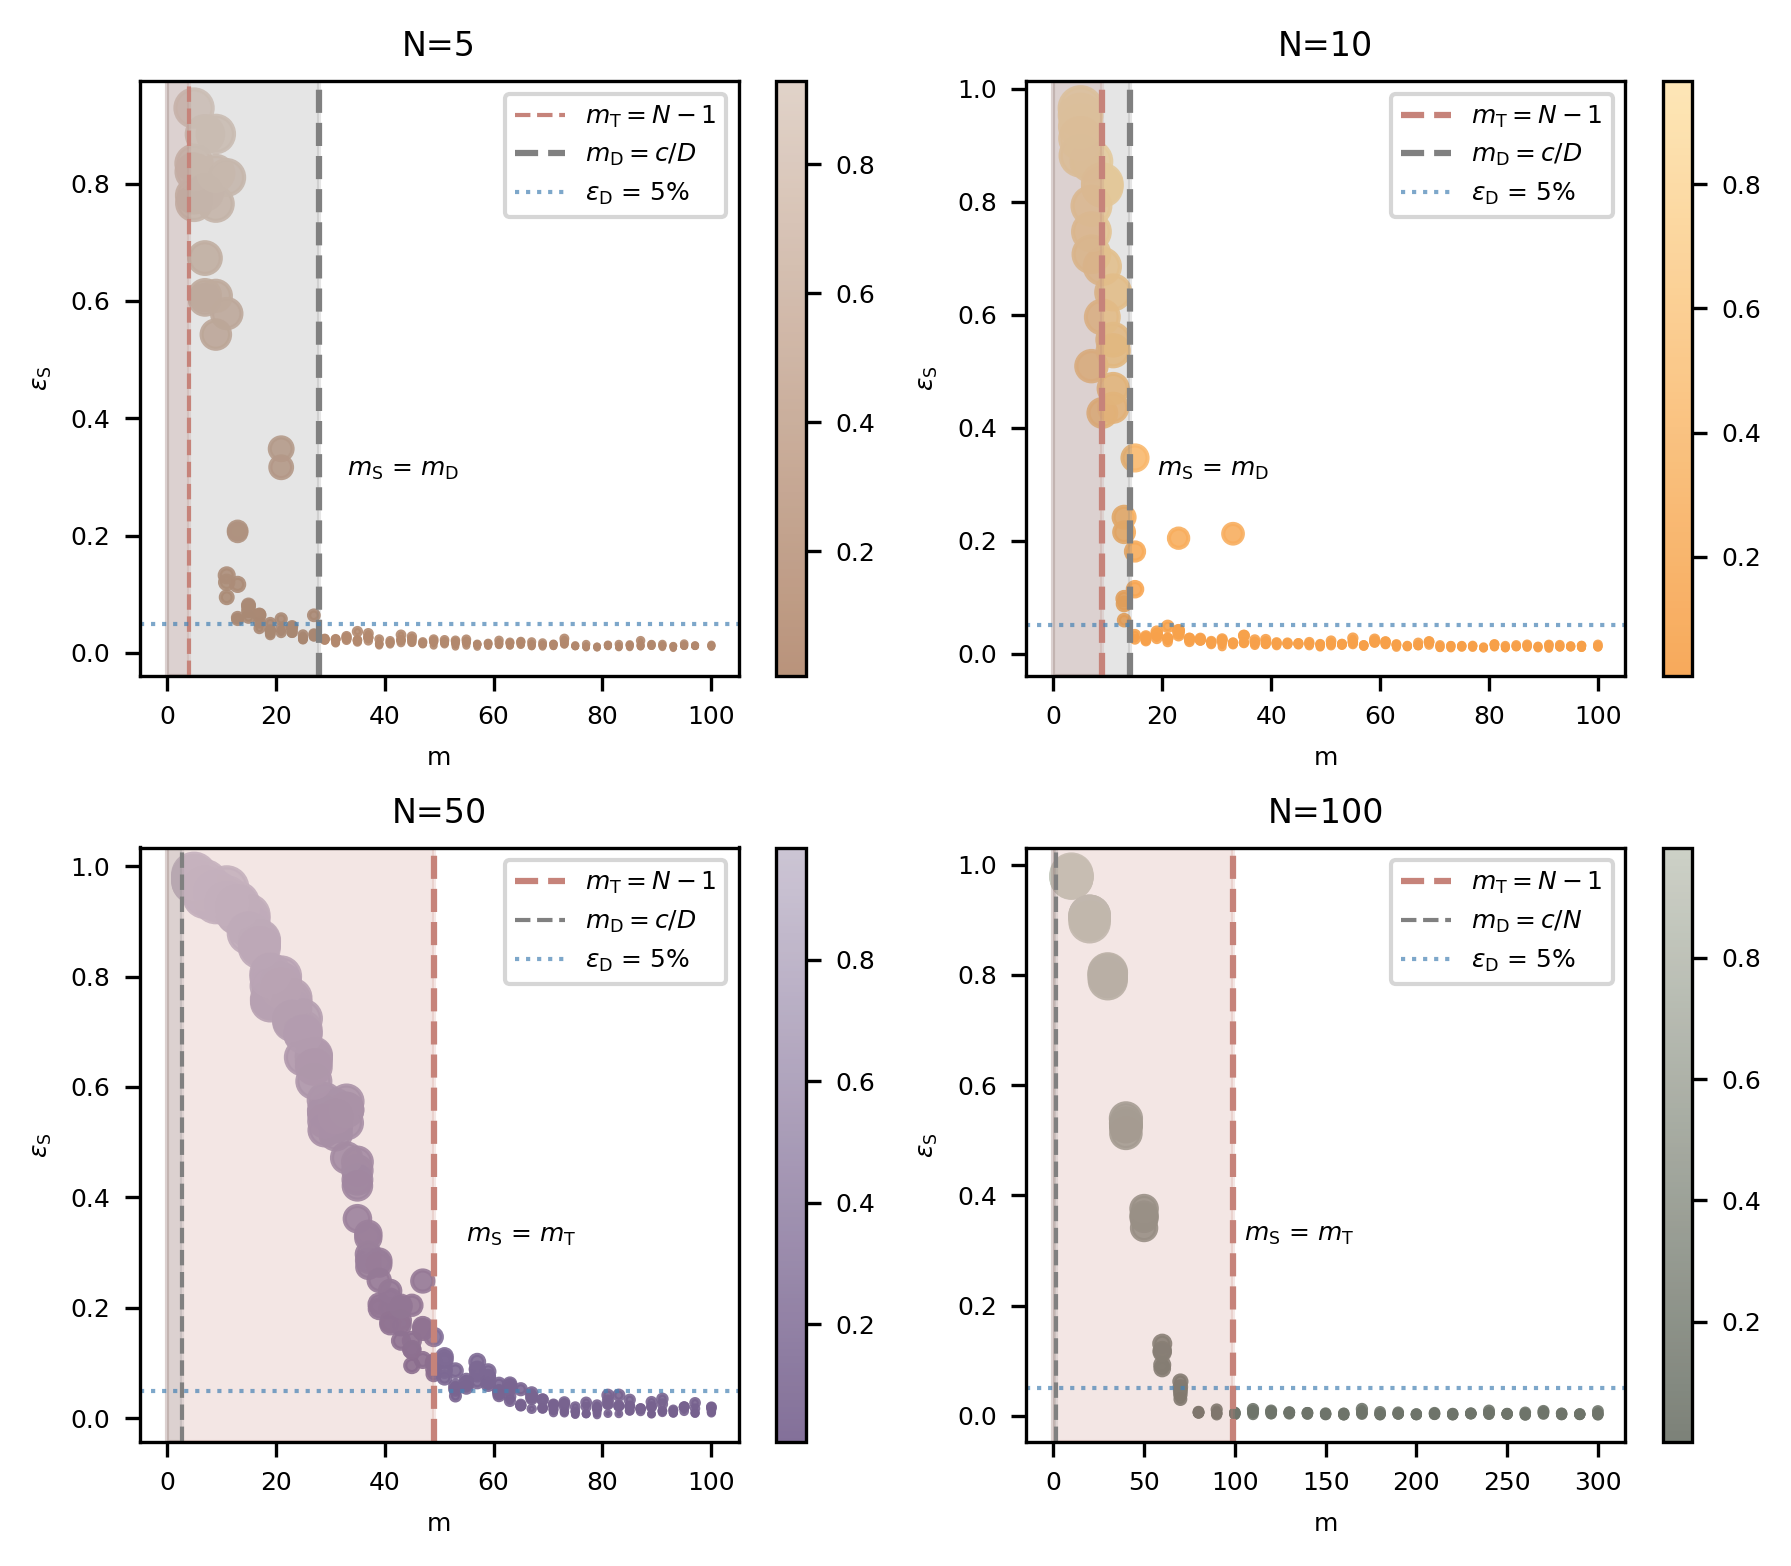

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 6
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(6,5.2))

N = 5
clrz = 140/N
colors = ['#B2886D','#DECEC3']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
sizes1 = (preError5 - (min(preError5)-0.005)) / (max(preError5)) * 80
sa1 = ax1.scatter(M5*len(ind), preError5, s = sizes1, c=preError5, cmap=custom_cmap, alpha=0.9)
cbar1 = fig.colorbar(sa1)
ax1.axvline(x=N-1, color='#C6837A', linestyle='--',linewidth = 1,label='$m_\mathrm{T}=N-1$')
ax1.axvspan(0, N-1, color='#C6837A', alpha=0.2)
ax1.axvline(x=clrz, color='gray', linestyle='--', linewidth = 1.5,label='$m_\mathrm{D}=c/D$')
ax1.axvspan(0, clrz, color='gray', alpha=0.2)
ax1.text(clrz + 5, 1/3*(min(preError5)+max(preError5)), '$m_\mathrm{S}$ = $m_\mathrm{D}$', verticalalignment='center')
ax1.axhline(y=0.05, color='steelblue', alpha=0.7, linestyle='dotted', linewidth = 1,label='$\epsilon_\mathrm{D}$ = 5%')
# ax1.set_xlim(-0.5,105)
# ax1.set_ylim(0.00,1)
ax1.legend()
ax1.set_xlabel('m')
ax1.set_ylabel('$\epsilon_\mathrm{S}$')
ax1.set_title(f'N={N}', fontsize=8)


N = 10
clrz = 140/N
colors = ['#f7a049','#fde4af']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
sizes1 = (preError10 - (min(preError10)-0.01)) / (max(preError10)) * 100
sa2 = ax2.scatter(M10*len(ind), preError10, s = sizes1, c=preError10, cmap=custom_cmap, alpha=0.9)
cbar2 = fig.colorbar(sa2)
ax2.axvline(x=N-1, color='#C6837A', linestyle='--',label='$m_\mathrm{T}=N-1$')
ax2.axvspan(0, N-1, color='#C6837A', alpha=0.2)   
ax2.axvline(x=clrz, color='gray', linestyle='--', linewidth = 1.5,label='$m_\mathrm{D}=c/D$')
ax2.axvspan(0, clrz, color='gray', alpha=0.2)
ax2.text(clrz + 5, 1/3*(min(preError10)+max(preError10)), '$m_\mathrm{S}$ = $m_\mathrm{D}$', verticalalignment='center')
ax2.axhline(y=0.05, color='steelblue', alpha=0.7, linestyle='dotted', linewidth = 1,label='$\epsilon_\mathrm{D}$ = 5%')
# ax2.set_xlim(-0.5,105)
ax2.legend()
ax2.set_xlabel('m')
ax2.set_ylabel('$\epsilon_\mathrm{S}$')
ax2.set_title(f'N={N}', fontsize=8)

N = 50
clrz = 140/N
colors = ['#76618E','#C7BFD0']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
sizes1 = (preError50 - (min(preError50)-0.01)) / (max(preError50)) * 100
sa3 = ax3.scatter(M50*len(ind), preError50, s = sizes1, c=preError50, cmap=custom_cmap, alpha=0.9)
cbar3 = fig.colorbar(sa3)
# cbar1.set_label('Dynamics prediction error')
ax3.axvline(x=N-1, color='#C6837A', linestyle='--',linewidth =1.5,label='$m_\mathrm{T}=N-1$')
ax3.axvspan(0, N-1, color='#C6837A', alpha=0.2)
ax3.axvline(x=clrz, color='gray', linestyle='--',linewidth = 1,label='$m_\mathrm{D}= c/D$')
ax3.axhline(y=0.05, color='steelblue', alpha=0.7, linestyle='dotted', linewidth = 1,label='$\epsilon_\mathrm{D}$ = 5%')
ax3.axvspan(0, clrz, color='gray', alpha=0.2)
ax3.text(N + 5, 1/3*(min(preError50)+max(preError50)), '$m_\mathrm{S}$ = $m_\mathrm{T}$', verticalalignment='center')
# ax3.set_xlim(-0.5,105)
ax3.legend()
ax3.set_xlabel('m')
ax3.set_ylabel('$\epsilon_\mathrm{S}$')
ax3.set_title(f'N={N}', fontsize=8)

N = 100
clrz = 140/N
colors = ['#6e746a','#c8ccc1']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
sizes1 = (preError100 - (min(preError100)-0.03)) / (max(preError100)) * 90
sa4 = ax4.scatter(M100*len(ind), preError100, s = sizes1, c=preError100, cmap=custom_cmap, alpha=0.9)
cbar4 = fig.colorbar(sa4)
# cbar1.set_label('Dynamics prediction error')
ax4.axvline(x=N-1, color='#C6837A', linestyle='--',linewidth = 1.5,label='$m_\mathrm{T}=N-1$')
ax4.axvspan(0, N-1, color='#C6837A', alpha=0.2)
ax4.axvline(x=clrz, color='gray', linestyle='--',linewidth = 1,label='$m_\mathrm{D}= c/N$')
ax4.axhline(y=0.05, color='steelblue', alpha=0.7, linestyle='dotted', linewidth = 1,label='$\epsilon_\mathrm{D}$ = 5%')
ax4.axvspan(0, clrz, color='gray', alpha=0.2)
ax4.text(N + 5, 1/3*(min(preError100)+max(preError100)), '$m_\mathrm{S}$ = $m_\mathrm{T}$', verticalalignment='center')
# ax4.set_xlim(-1,305)
ax4.legend()
ax4.set_xlabel('m')
ax4.set_ylabel('$\epsilon_\mathrm{S}$')
ax4.set_title(f'N={N}', fontsize=8)
fig.tight_layout()
# plt.savefig(f'simul_infer/simul_errorall.png', dpi=300)
# plt.savefig(f'simul_infer/simul_errorall_new.pdf', dpi=300)


Text(0.5, 0.98, 'Network size N=5')

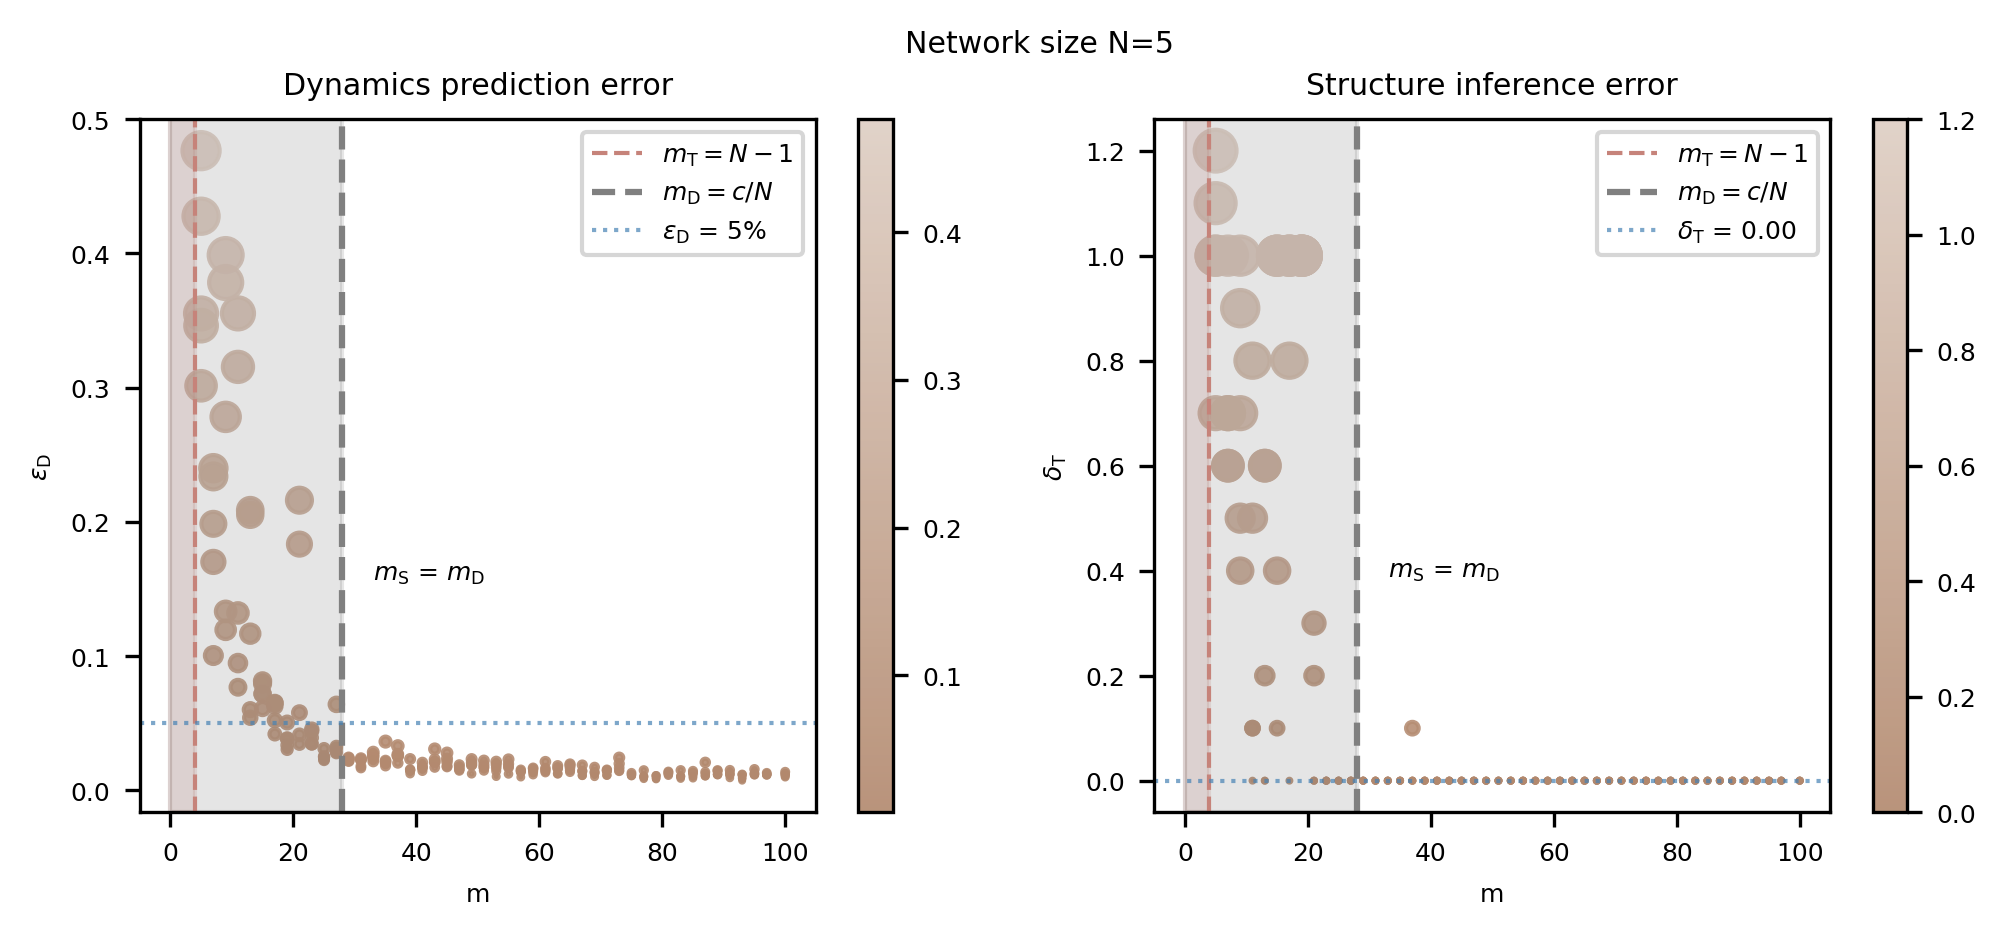

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = ['#B2886D','#DECEC3']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

sizes1 = (preError5 - (min(preError5)-0.005)) / (max(preError5)) * 80

N = 5
clrz = 140/N
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 6
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))

sa1 = ax1.scatter(M5*len(ind), preError5, s = sizes1, c=preError5, cmap=custom_cmap, alpha=0.9)
cbar1 = fig.colorbar(sa1)
ax1.axvline(x=N-1, color='#C6837A', linestyle='--',linewidth = 1,label='$m_\mathrm{T}=N-1$')
ax1.axvspan(0, N-1, color='#C6837A', alpha=0.2)
ax1.axvline(x=clrz, color='gray', linestyle='--', linewidth = 1.5,label='$m_\mathrm{D}=c/N$')
ax1.axvspan(0, clrz, color='gray', alpha=0.2)
ax1.text(clrz + 5, 1/3*(min(preError5)+max(preError5)), '$m_\mathrm{S}$ = $m_\mathrm{D}$', verticalalignment='center')
ax1.axhline(y=0.05, color='steelblue', alpha=0.7, linestyle='dotted', linewidth = 1,label='$\epsilon_\mathrm{D}$ = 5%')
# ax1.set_yscale('log')
ax1.set_xlim(-5,105)
# ax1.set_ylim(0.00,1)
ax1.legend()
ax1.set_xlabel('m')
ax1.set_ylabel('$\epsilon_\mathrm{D}$')
ax1.set_title('Dynamics prediction error')


sizes2 = ((error5 - (min(error5)-0.01)) / (max(error5))) * 100
sa2 = ax2.scatter(M5*len(ind), error5, s=sizes2, c=error5, cmap=custom_cmap, alpha = 0.9)
cbar2 = fig.colorbar(sa2)
ax2.set_xlabel('m')
ax2.set_ylabel('$\delta_\mathrm{T}$')
ax2.axvline(x=N-1, color='#C6837A', linestyle='--',linewidth = 1, label='$m_\mathrm{T}=N-1$')
ax2.axvspan(0, N-1, color='#C6837A', alpha=0.2)
ax2.axvline(x=clrz, color='grey', linestyle='--',linewidth = 1.5,label='$m_\mathrm{D}=c/N$')
ax2.axvspan(0,clrz, color='gray', alpha=0.2)
ax2.text(clrz + 5,1/3*(min(error5)+max(error5)), '$m_\mathrm{S}$ = $m_\mathrm{D}$', verticalalignment='center')
ax2.axhline(y=0.00, color='steelblue', alpha=0.7, linestyle='dotted', linewidth = 1,label='$\delta_\mathrm{T}$ = 0.00')
ax2.legend()
# ax2.set_yscale('log')
# ax2.set_ylim(0.00,1.5)
ax2.set_xlim(-5,105)
ax2.set_title('Structure inference error')

plt.suptitle(f'Network size N={N}')
# plt.savefig(f'simul_infer/simul_scatter_error_N{N}_scale_c140.pdf')
# plt.savefig(f'simul_infer/simul_scatter_error_N{N}_scale_c140.png')    


Text(0.5, 0.98, 'Network size N=10')

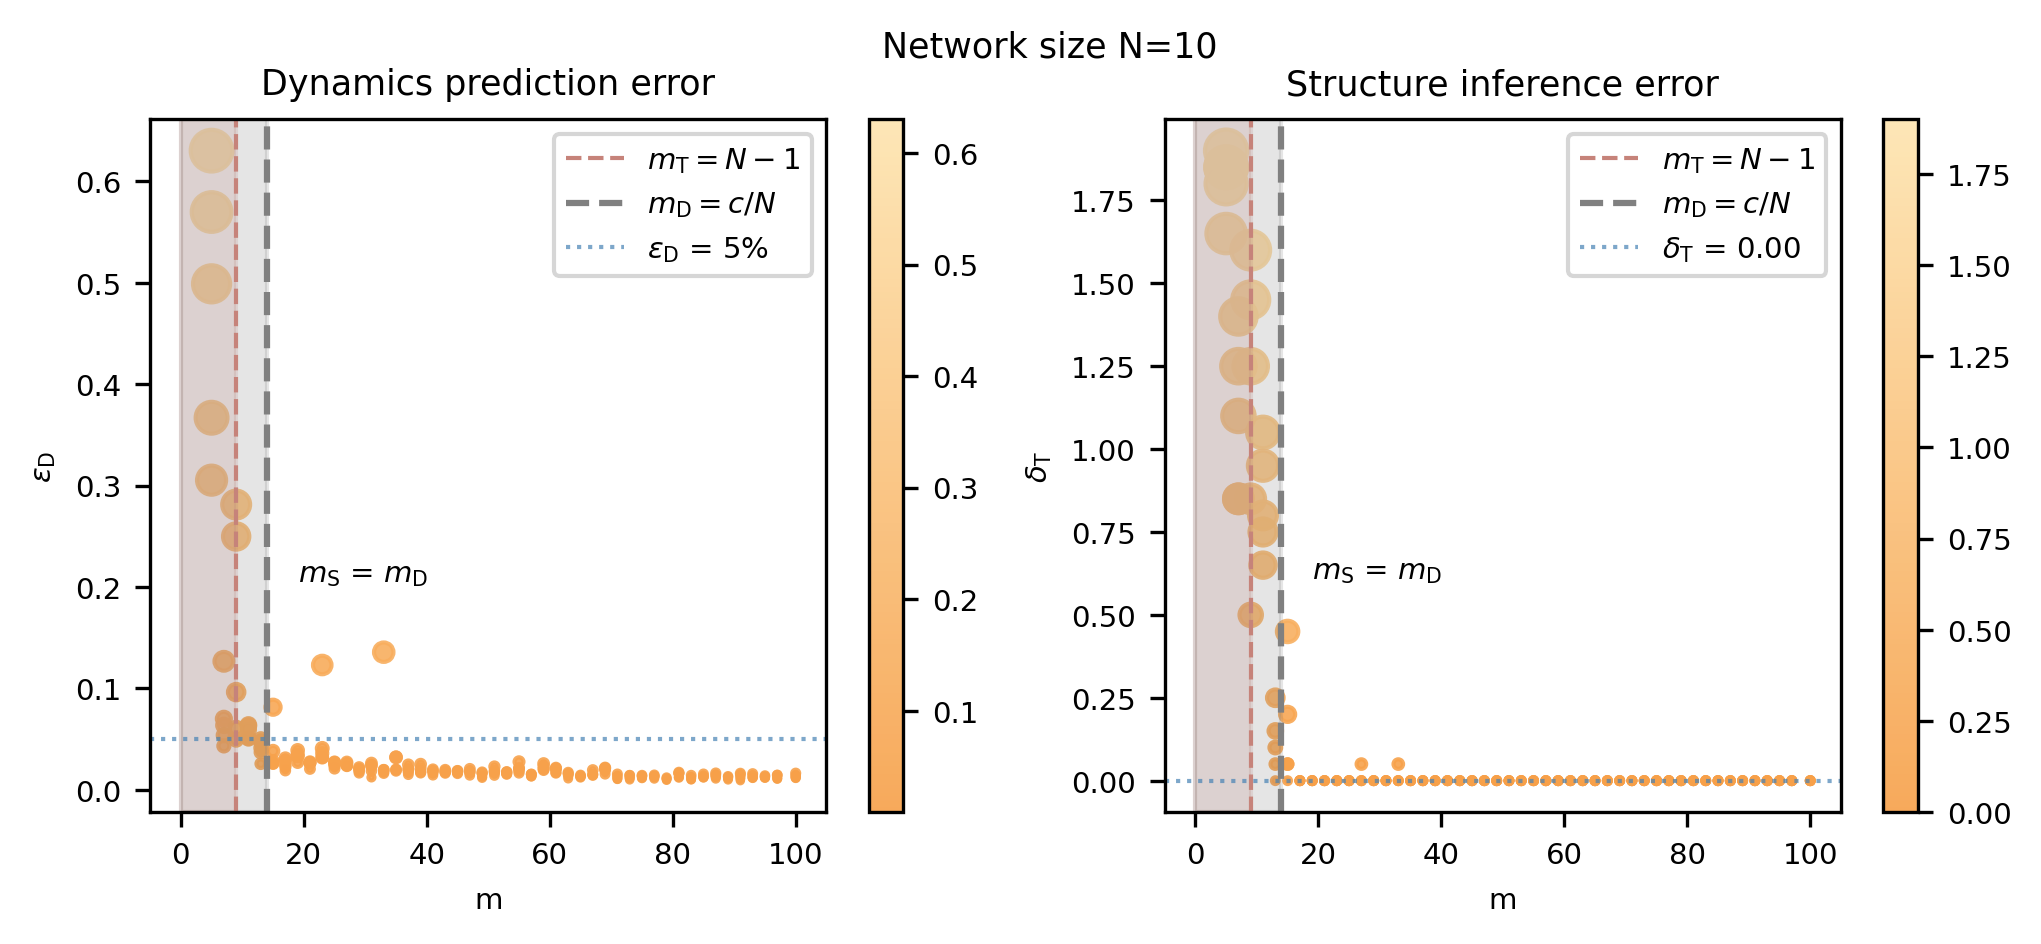

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = ['#f7a049','#fde4af']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

sizes1 = (preError10 - (min(preError10)-0.01)) / (max(preError10)) * 100

N = 10
clrz = 140/N
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 7
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8, 3))

sa1 = ax1.scatter(M10*len(ind), preError10, s = sizes1, c=preError10, cmap=custom_cmap, alpha=0.9)
cbar1 = fig.colorbar(sa1)
ax1.axvline(x=N-1, color='#C6837A', linestyle='--',linewidth = 1,label='$m_\mathrm{T}=N-1$')
ax1.axvspan(0, N-1, color='#C6837A', alpha=0.2)
ax1.axvline(x=clrz, color='gray', linestyle='--', linewidth = 1.5,label='$m_\mathrm{D}=c/N$')
ax1.axvspan(0, clrz, color='gray', alpha=0.2)
ax1.text(clrz + 5, 1/3*(min(preError10)+max(preError10)), '$m_\mathrm{S}$ = $m_\mathrm{D}$', verticalalignment='center')
ax1.axhline(y=0.05, color='steelblue', alpha=0.7, linestyle='dotted', linewidth = 1,label='$\epsilon_\mathrm{D}$ = 5%')
ax1.set_xlim(-5,105)
ax1.legend()
ax1.set_xlabel('m')
ax1.set_ylabel('$\epsilon_\mathrm{D}$')
ax1.set_title('Dynamics prediction error')


sizes2 = ((error10 - (min(error10)-0.05)) / (max(error10))) * 100
sa2 = ax2.scatter(M10*len(ind), error10, s=sizes2, c=error10, cmap=custom_cmap, alpha = 0.9)
cbar2 = fig.colorbar(sa2)
ax2.set_xlabel('m')
ax2.set_ylabel('$\delta_\mathrm{T}$')
ax2.axvline(x=N-1, color='#C6837A', linestyle='--',linewidth = 1, label='$m_\mathrm{T}=N-1$')
ax2.axvspan(0, N-1, color='#C6837A', alpha=0.2)
ax2.axvline(x=clrz, color='grey', linestyle='--',linewidth = 1.5,label='$m_\mathrm{D}=c/N$')
ax2.axvspan(0,clrz, color='gray', alpha=0.2)
ax2.text(clrz + 5,1/3*(min(error10)+max(error10)), '$m_\mathrm{S}$ = $m_\mathrm{D}$', verticalalignment='center')
ax2.axhline(y=0.00, color='steelblue', alpha=0.7, linestyle='dotted', linewidth = 1,label='$\delta_\mathrm{T}$ = 0.00')
ax2.legend()
ax2.set_xlim(-5,105)
ax2.set_title('Structure inference error')
plt.suptitle(f'Network size N={N}')
# plt.savefig(f'simul_infer/simul_scatter_error_N{N}_scale_c140.pdf')
# plt.savefig(f'simul_infer/simul_scatter_error_N{N}_scale_c140.png') 


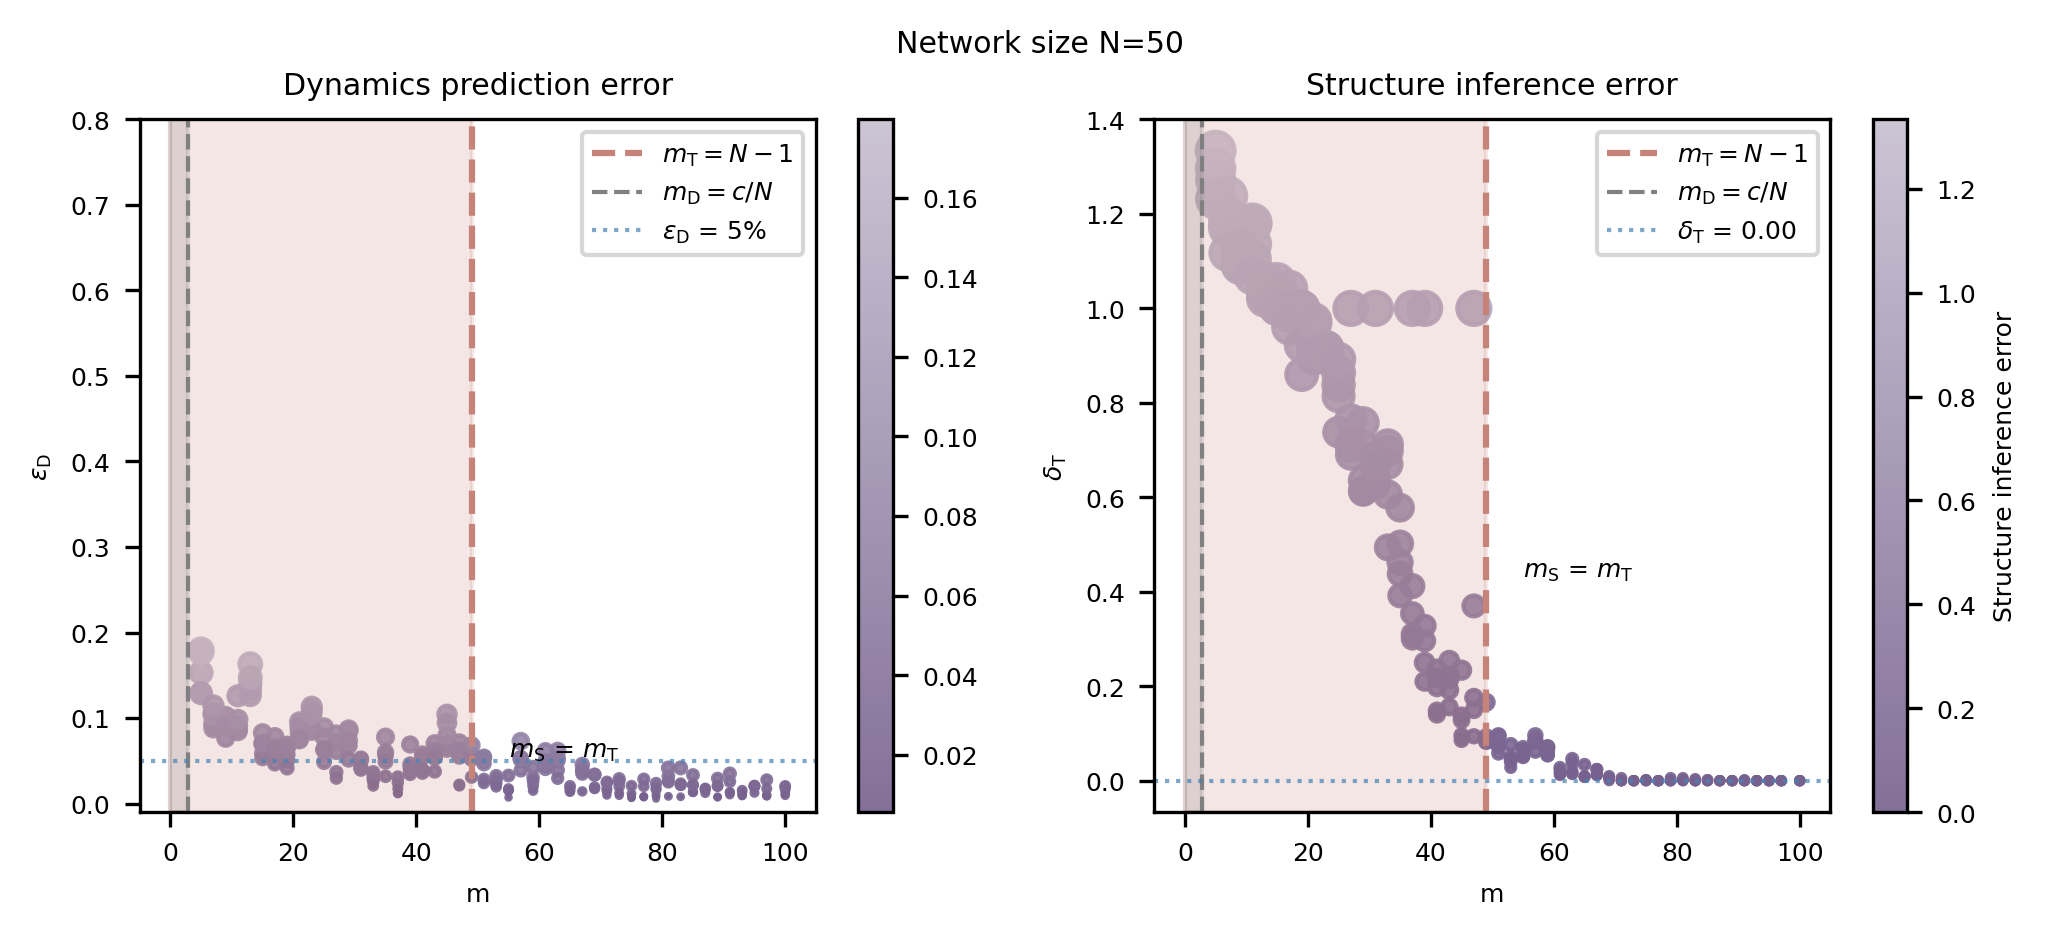

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = ['#76618E','#C7BFD0']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

sizes1 = (preError50 - (min(preError50)-0.005)) / (max(preError50)) * 30
N = 50
clrz = 140/N
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 6
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8, 3))

sa1 = ax1.scatter(M50*len(ind), preError50, s = sizes1, c=preError50, cmap=custom_cmap, alpha=0.9)
cbar1 = fig.colorbar(sa1)
ax1.axvline(x=N-1, color='#C6837A', linestyle='--',linewidth =1.5,label='$m_\mathrm{T}=N-1$')
ax1.axvspan(0, N-1, color='#C6837A', alpha=0.2)
ax1.axvline(x=clrz, color='gray', linestyle='--',linewidth = 1,label='$m_\mathrm{D}= {c}/{N}$')
ax1.axhline(y=0.05, color='steelblue', alpha=0.7, linestyle='dotted', linewidth = 1,label='$\epsilon_\mathrm{D}$ = 5%')
ax1.axvspan(0, clrz, color='gray', alpha=0.2)
ax1.text(N + 5, 1/3*(min(preError50)+max(preError50)), '$m_\mathrm{S}$ = $m_\mathrm{T}$', verticalalignment='center')
# ax1.set_yscale('log')
ax1.set_ylim(-0.01,0.8)
ax1.set_xlim(-5,105)
ax1.legend()
ax1.set_xlabel('m')
ax1.set_ylabel('$\epsilon_\mathrm{D}$')
ax1.set_title('Dynamics prediction error')

sizes2 = ((error50 - (min(error50)-0.05)) / (max(error50))) * 80
sa2 = ax2.scatter(M50*len(ind), error50, s=sizes2, c=error50, cmap=custom_cmap, alpha = 0.9)
cbar2 = fig.colorbar(sa2)
cbar2.set_label('Structure inference error')
ax2.set_xlabel('m')
ax2.set_ylabel('$\delta_\mathrm{T}$')
ax2.axvline(x=N-1, color='#C6837A', linestyle='--',linewidth =1.5,label='$m_\mathrm{T}=N-1$')
ax2.axvspan(0, N-1, color='#C6837A', alpha=0.2)
ax2.axvline(x=clrz, color='gray', linestyle='--',linewidth = 1,label='$m_\mathrm{D}={c}/{N}$')
ax2.axvspan(0, clrz, color='gray', alpha=0.2)
ax2.axhline(y=0.00, color='steelblue', alpha=0.7, linestyle='dotted', linewidth = 1,label='$\delta_\mathrm{T}$ = 0.00')
ax2.text(N + 5, 1/3*(min(error50)+max(error50)), '$m_\mathrm{S}$ = $m_\mathrm{T}$', verticalalignment='center')
ax2.set_xlim(-5,105)
ax2.legend()
ax2.set_title('Structure inference error')

plt.suptitle(f'Network size N={N}')
# plt.savefig(f'simul_infer/simul_scatter_error_N{N}_scale_c140.pdf')

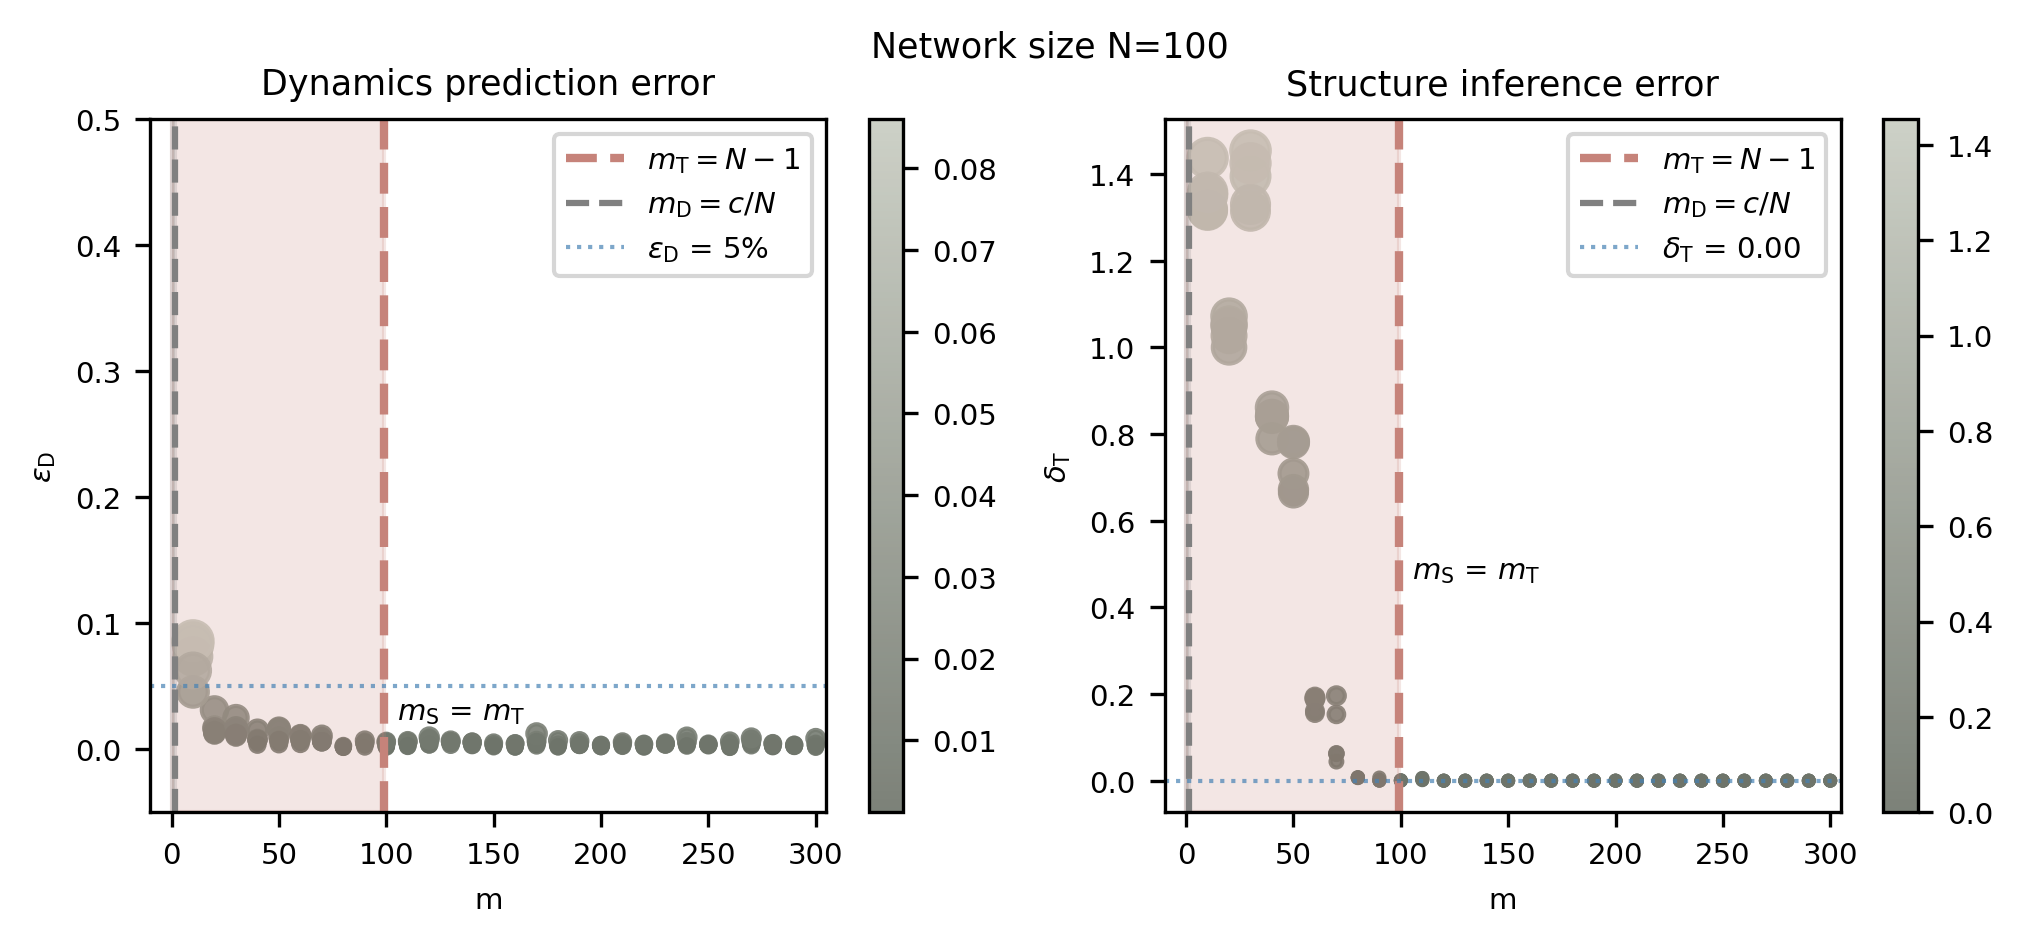

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = ['#6e746a','#c8ccc1']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

sizes1 = (preError100 - (min(preError100)-0.01)) / (max(preError100)) * 80

N = 100
clrz = 140/N
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 7
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8, 3))

sa1 = ax1.scatter(M100*len(ind), preError100, s = sizes1, c=preError100, cmap=custom_cmap, alpha=0.9)
cbar1 = fig.colorbar(sa1)
ax1.axvline(x=N-1, color='#C6837A', linestyle='--',linewidth = 2, label='$m_\mathrm{T}=N-1$')
ax1.axvspan(0, N-1, color='#C6837A', alpha=0.2)
ax1.axvline(x=clrz, color='gray', linestyle='--',label='$m_\mathrm{D}=c/N$')
ax1.axvspan(0, clrz, color='gray', alpha=0.2)
ax1.text(N + 5, 1/3*(min(preError100)+max(preError100)), '$m_\mathrm{S}$ = $m_\mathrm{T}$', verticalalignment='center')
ax1.axhline(y=0.05, color='steelblue', alpha=0.7, linestyle='dotted', linewidth = 1,label='$\epsilon_\mathrm{D}$ = 5%')
ax1.set_xlim(-10,305)
ax1.set_ylim(-0.05,0.5)
ax1.legend()
ax1.set_xlabel('m')
ax1.set_ylabel('$\epsilon_\mathrm{D}$')
ax1.set_title('Dynamics prediction error')


sizes2 = ((error100 - (min(error100)-0.1)) / (max(error100))) * 80
sa2 = ax2.scatter(M100*len(ind), error100, s=sizes2, c=error100, cmap=custom_cmap, alpha = 0.9)
cbar2 = fig.colorbar(sa2)
ax2.set_xlabel('m')
ax2.set_ylabel('$\delta_\mathrm{T}$')
ax2.axvline(x=N-1, color='#C6837A', linestyle='--',linewidth = 2,label='$m_\mathrm{T}=N-1$')
ax2.axvspan(0, N-1, color='#C6837A', alpha=0.2)
ax2.axvline(x=clrz, color='grey', linestyle='--',label='$m_\mathrm{D}=c/N$')
ax2.axvspan(0, clrz, color='gray', alpha=0.2)
ax2.text(N + 5,1/3*(min(error100)+max(error100)), '$m_\mathrm{S}$ = $m_\mathrm{T}$', verticalalignment='center')
ax2.axhline(y=0.00, color='steelblue', alpha=0.7, linestyle='dotted', linewidth = 1,label='$\delta_\mathrm{T}$ = 0.00')
ax2.legend()
ax2.set_xlim(-10,305)
# ax2.set_ylim(-0.05,0.5)
ax2.set_title('Structure inference error')

plt.suptitle(f'Network size N={N}')
# plt.savefig(f'simul_infer/simul_scatter_error_N{N}_scale_c140.pdf')
# plt.savefig(f'simul_infer/simul_scatter_error_N{N}_color2_shadow.png')    
